# Charlie Browning - ST20251063
# DAT4004 - WRIT1

## Step 1 - Reading and cleaning the data
#### Step 1 includes the reading/processing of the data, along with the cleansing of the data in order to prepare it for use in training my model. My model aims to predict the winner of a CDL hardpoint game, using data from previous matches that have occured across the 2023 CDL season.  
#### After reading in the separate data files (from the data folder) and combining each of these smaller files into one large dataset, I will clean the data thoroughly. This includes not only reducing the number of dimensions of my dataset, but also removing outliers and missing data in order to ensure that my data is as reliable as possible.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

data_file_names = os.listdir("data")
print(f"There are {len(data_file_names)} matches stored in the data folder, which will be used to train my model")

There are 135 matches stored in the data folder, which will be used to train my model


Next, I will wriite a function to read in all of the matches and combine them into one dataset

In [2]:
def read_in_matches(data_location: str='data') -> pd.DataFrame:
    """
    Desc: A function to read in all of the match data files and combined them into one
          pandas dataframe
    Params:
        data_location (string) - The location of the folder containing the match data
    Returns:
        pd.DataFrame - A dataframe containing the combined match data                          
    """
    parts = []
    for file_location in os.listdir(data_location):
        parts.append(pd.read_csv(f"{data_location}/{file_location}"))
    return pd.concat(parts, axis=0).reset_index()

all_matches = read_in_matches()
all_matches.sample(5)
all_matches.shape

(4352, 103)

In order to be able to determine who the winner of a map is from my model, I must first add a new column to the current dataset that clearly indicates who won the map (In call of duty, 1 map = one game, 5 maps = series. This follows the commonly used best of 5 format). This will also be known as the label in my model

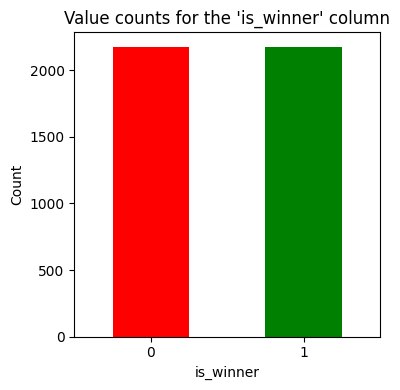

In [3]:
def declare_winner(df: pd.DataFrame) -> pd.DataFrame:
    """
    Desc: A function to add a new variable to a dataframe indicating if that player
          won the 'map'
    """
    df['map_winner'] = ["host" if a > b else "guest" for a, b in zip(df['matchGameResult.hostGameScore'], df['matchGameResult.guestGameScore'])]
    df['is_winner'] = [1 if a == b else 0 for a, b in zip(df['map_winner'], df['team_type'])]
    # The map_winner column can be dropped in the returned df because it is only needed to determine our label (the is_winner column)
    df.drop('map_winner', axis=1, inplace=True)
    return df


def plot_value_counts(df: pd.DataFrame, variable: str, axis: plt.axis, colors: list=None) -> None:
    """
    Desc: A function to plot value counts for a column onto a given axis
    """
    if colors:
        df[variable].value_counts().plot(kind='bar', ax=axis, color=colors)
    else:
        df[variable].value_counts().plot(kind='bar', ax=axis)
    
    ax1.tick_params(rotation=0)
    ax1.set_ylabel("Count")
    ax1.set_title(f"Value counts for the '{variable}' column")

winners_df = declare_winner(all_matches)

fig = plt.figure(figsize=(4, 4), layout='tight')
ax1 = fig.subplots()

plot_value_counts(winners_df, 'is_winner', ax1, ['red', 'green'])

The graph shows an equal number of winners and losers, which is expected as both teams have the same number of players, therefore meaning each map should have 4 winners and 4 losers.  

Next I will reduce the number of columns in the data as it is evident that there are too many. The columns that I select will be the ones that are relevant in determining the winner of a Hardpoint map

In [4]:
# Display all of the columns in the dataset
all_matches.columns.values

array(['index', 'gameMap', 'gameMode', 'id', 'programId', 'firstName',
       'lastName', 'alias', 'headshot', 'socialNetworkHandles',
       'averageSpeed', 'highestStreak', 'untradedKills', 'untradedDeaths',
       'tradedKills', 'tradedDeaths', 'inapplicableTradedKills',
       'inapplicableTradedDeaths', 'damageTaken', 'damageHealed',
       'tacticalsUsed', 'lethalsUsed', 'percentTimeMoving',
       'deadSilenceTime', 'hillTime', 'contestedHillTime',
       'esportsTournamentId', 'totalKills', 'totalDeaths', 'totalAssists',
       'totalScore', 'totalShotsFired', 'totalShotsHit', 'totalShotsHead',
       'totalDamageDealt', 'friendDamage', 'totalTimeAlive',
       'totalDistanceTraveled', 'highestMultikill', 'totalAces',
       'totalInVictimFovKills', 'totalDefuserKills',
       'totalFirstBloodKills', 'totalLongshotKills', 'totalPlanterKills',
       'totalPointblankKills', 'totalRevengeKills', 'totalRotationKills',
       'totalInAttackerFovKills', 'totalWallbangKills', 'killDe

In [5]:
needed_columns = ['totalKills', 'totalDeaths', 'totalRotationKills', 'is_winner', 'abbrev', 'totalDamageDealt', 'damageTaken', 'tradedDeaths', 'tradedKills', 'untradedKills', 'untradedDeaths',
                  'matchGame.matchId', 'gameMode', 'gameMap']
# Column Descriptions
# totalKills - The total number of kills a player has in a map
# totalDeaths - The total number of deaths a player has in a map
# totalRotationKills - The total number of kills a player has while rotating to the new hardpoint/hill
# is_winner - Whether or not the player won that map (1=Yes, 0=No)
# totalDamageDealt - The total number of damage a player has dealt in a map
# damageTaken - The total number of damage a player has taken in a map
# tradedDeaths - The total number of deaths a player has in a map that were traded (their teammate killed the person who killed- 
#                them (player) shortly after they died)
# tradedKills - The total number of times a player has died shortly after getting a kill
# untradedKills - The total number of kills a player has where he wasn't killed afterwards in a short amount of time
# untradedDeaths - The total number of deaths a player has where their teammates failed to 'avenge' them shortly after
# matchGame.matchId - The ID for the match, used to ensure groupings are consistent to the same map and game (when grouping up-
#                     to teams)
# gameMode - The gameMode of the map played by the player
# gameMap - The name of the map played by the player

refined_df = winners_df[needed_columns]
refined_df.sample(5)

,totalKills,totalDeaths,totalRotationKills,is_winner,abbrev,totalDamageDealt,damageTaken,tradedDeaths,tradedKills,untradedKills,untradedDeaths,matchGame.matchId,gameMode,gameMap
3759,34.0,21.0,9.0,1,BOS,4070.0,2715.0,4.0,7.0,27.0,17.0,8747,CDL Hardpoint,Breenbergh Hotel
410,36.0,33.0,7.0,1,BOS,3927.0,4059.0,11.0,11.0,25.0,23.0,10118,CDL Hardpoint,Al Bagra Fortress
3941,7.0,6.0,0.0,1,MIN,1019.0,757.0,0.0,2.0,4.0,5.0,8763,CDL SnD,Mercado Las Almas
3125,8.0,5.0,0.0,1,LV,1019.0,838.0,0.0,0.0,8.0,4.0,8726,CDL SnD,El Asilo
1585,20.0,11.0,4.0,1,BOS,2246.0,1556.0,6.0,3.0,17.0,5.0,8654,CDL Hardpoint,Breenbergh Hotel


Now that I have reduced the number of columns in the data, I will group the data by team for each individual map that a team has played, which allows for teams to be compared rather than players. This is essential for the model to work correctly as it must have data for complete teams rather than individual players.  
The data will be specifically grouped by abbrev, matchGame.matchId, gameMap and gameMode. This will ensure that each row represents a singular map played. Abbrev will group by team, matchGame.matchId will group by the match (best of 5) itself, gameMap will group by the name of the map being played and gameMode will group by the mode of that map (the same map and mode combo can't be played twice in one series)

In [6]:
# Group the data down to individual maps played
grouping_vars = ['abbrev', 'matchGame.matchId', 'gameMap', 'gameMode']
team_df = refined_df.groupby(grouping_vars).sum()
team_df.sample(5)

,,,,totalKills,totalDeaths,totalRotationKills,is_winner,totalDamageDealt,damageTaken,tradedDeaths,tradedKills,untradedKills,untradedDeaths
abbrev,matchGame.matchId,gameMap,gameMode,,,,,,,,,,
TOR,8731,Breenbergh Hotel,CDL Hardpoint,87.0,91.0,17.0,4,10914.0,11038.0,26.0,27.0,60.0,65.0
LV,8651,El Asilo,CDL SnD,27.0,24.0,0.0,4,3631.0,3300.0,4.0,1.0,20.0,17.0
TOR,10890,El Asilo,CDL SnD,26.0,19.0,0.0,4,3450.0,2741.0,1.0,1.0,19.0,15.0
TX,10895,Mercado Las Almas,CDL SnD,31.0,22.0,0.0,4,4129.0,2946.0,5.0,5.0,20.0,13.0
ATL,8646,Al Bagra Fortress,CDL SnD,17.0,26.0,0.0,0,3025.0,4096.0,2.0,4.0,11.0,19.0


To ensure that the is_winner column (my label) remains binary, I must ensure that instances where a team has won the map appear as 1 and not 4

In [7]:
# Replace 4 with 1 in the is_winner column
team_df['is_winner'] = [og if og == 0 else 1 for og in team_df['is_winner']]
print(f"The unqiue values in the is_winner column are: {team_df['is_winner'].unique()}")

The unqiue values in the is_winner column are: [1 0]


Now that this issue has been resolved within the data, I can filter the data to only include the hardpoint gamemode, as this is the gamemode that I am trying to predict the outcome of.

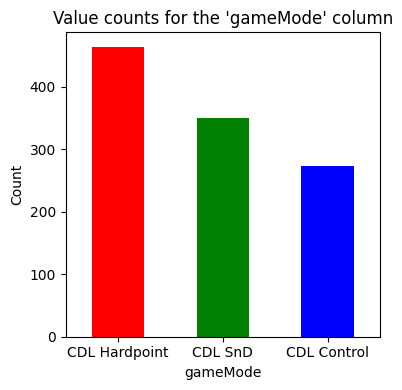

In [8]:
# Reset the index so that columns used in grouping remain as column
team_df.reset_index(inplace=True)

# Plot value counts for the game modes
fig = plt.figure(figsize=(4, 4), layout='tight')
ax1 = fig.subplots()
plot_value_counts(team_df, 'gameMode', ax1, ['red', 'green', 'blue'])

From the value counts, we can see that Hardpoint is the majority gamemode, meaning that we will still have a large amount of data to work from after removing the other two gamemodes from the dataset.

In [9]:
# Create a dataset with only the hardpoint data
hp_df = team_df.copy()[team_df['gameMode']=='CDL Hardpoint'].reset_index(drop=True)
print(f"The unqiue values in the gameMode column are: {hp_df['gameMode'].unique()}")

The unqiue values in the gameMode column are: ['CDL Hardpoint']


Now that I have manipulated our dataset to only show the relevant data for the creation of my model, I can look at removing anomalies and further cleaning the data. Firstly, I will look at plotting variable against eachother to determine if there are any obvious outliers. I will plot variables that have a significant relationship (in terms of the game itself) to begin with 

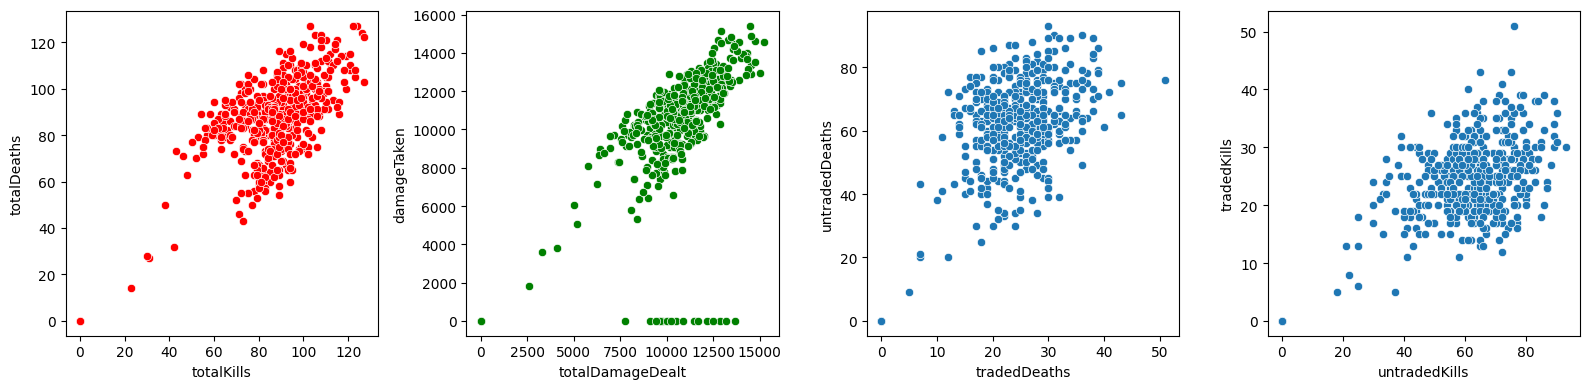

In [10]:
import seaborn as sns

# Plot the comparisons on one figure
fig = plt.figure(figsize=(16, 4), layout='tight')
ax1, ax2, ax3, ax4 = fig.subplots(ncols=4)

sns.scatterplot(data=hp_df, x='totalKills', y='totalDeaths', ax=ax1, color='red')
sns.scatterplot(data=hp_df, x='totalDamageDealt', y='damageTaken', ax=ax2, color='green')
sns.scatterplot(data=hp_df, x='tradedDeaths', y='untradedDeaths', ax=ax3)
sns.scatterplot(data=hp_df, x='untradedKills', y='tradedKills', ax=ax4);

From the first graph, it can be seen that some there are games with 0 kills and 0 deaths

In [11]:
hp_df[hp_df['totalKills']==0]

,abbrev,matchGame.matchId,gameMap,gameMode,totalKills,totalDeaths,totalRotationKills,is_winner,totalDamageDealt,damageTaken,tradedDeaths,tradedKills,untradedKills,untradedDeaths
57,BOS,8712,Embassy,CDL Hardpoint,0.0,0.0,19.0,1,0.0,0.0,0.0,0.0,0.0,0.0
430,TX,8712,Embassy,CDL Hardpoint,0.0,0.0,15.0,0,0.0,0.0,0.0,0.0,0.0,0.0


As there this is a very small number of rows, I have decided that these rows can be dropped. They are also both from the same match/map

In [12]:
# Drop rows where there aren't any kills
hp_df = hp_df[hp_df['totalKills'] > 0]

# Games where there are an unusually small number of kills and deaths
hp_df[hp_df['totalKills'] <= 45]

,abbrev,matchGame.matchId,gameMap,gameMode,totalKills,totalDeaths,totalRotationKills,is_winner,totalDamageDealt,damageTaken,tradedDeaths,tradedKills,untradedKills,untradedDeaths
186,LAT,8766,Zarqwa Hydroelectric,CDL Hardpoint,42.0,32.0,19.0,1,5180.0,5042.0,12.0,5.0,37.0,20.0
203,LDN,8643,Breenbergh Hotel,CDL Hardpoint,43.0,73.0,10.0,0,5771.0,8105.0,18.0,18.0,25.0,55.0
364,SEA,8766,Zarqwa Hydroelectric,CDL Hardpoint,38.0,50.0,8.0,0,5039.0,6034.0,7.0,13.0,25.0,43.0
366,SEA,8767,Zarqwa Hydroelectric,CDL Hardpoint,31.0,27.0,25.0,1,4120.0,3798.0,7.0,6.0,25.0,20.0
404,TOR,8767,Zarqwa Hydroelectric,CDL Hardpoint,30.0,28.0,22.0,0,3308.0,3614.0,7.0,8.0,22.0,21.0
443,TX,8775,Mercado Las Almas,CDL Hardpoint,23.0,14.0,20.0,1,2609.0,1843.0,5.0,5.0,18.0,9.0


I will now investigate these instances and identify where the problem is

In [13]:
# Test Case 1 - Match 8766
match_8766 = all_matches[all_matches['matchGame.matchId']==8766]
match_8766[match_8766['gameMode']=='CDL Hardpoint'][['alias', 'gameMap', 'totalKills', 'totalDeaths']]

,alias,gameMap,totalKills,totalDeaths
4024,Accuracy,Zarqwa Hydroelectric,24.0,26.0
4025,Kenny,Zarqwa Hydroelectric,21.0,13.0
4026,Mack,Zarqwa Hydroelectric,0.0,0.0
4027,Octane,Zarqwa Hydroelectric,0.0,0.0
4028,Sib,Zarqwa Hydroelectric,0.0,0.0
4029,Envoy,Zarqwa Hydroelectric,0.0,0.0
4030,Pred,Zarqwa Hydroelectric,14.0,24.0
4031,Drazah,Zarqwa Hydroelectric,21.0,19.0
4048,Accuracy,Embassy,22.0,23.0
4049,Kenny,Embassy,22.0,18.0


In [14]:
# Test Case 2 - Match 8767
match_8767 = all_matches[all_matches['matchGame.matchId']==8767]
match_8767[match_8767['gameMode']=='CDL Hardpoint'][['alias', 'gameMap', 'totalKills', 'totalDeaths']]

,alias,gameMap,totalKills,totalDeaths
4056,Accuracy,Zarqwa Hydroelectric,0.0,0.0
4057,CleanX,Zarqwa Hydroelectric,30.0,28.0
4058,Mack,Zarqwa Hydroelectric,0.0,0.0
4059,Insight,Zarqwa Hydroelectric,0.0,0.0
4060,Sib,Zarqwa Hydroelectric,31.0,27.0
4061,Hicksy,Zarqwa Hydroelectric,0.0,0.0
4062,Pred,Zarqwa Hydroelectric,0.0,0.0
4063,Scrap,Zarqwa Hydroelectric,0.0,0.0
4080,Accuracy,Al Bagra Fortress,21.0,23.0
4081,CleanX,Al Bagra Fortress,35.0,23.0


It can be seen from the test cases that some players were not having their statistics recorded correctly. I will also drop these cases from the dataset (totalKills <= 40)

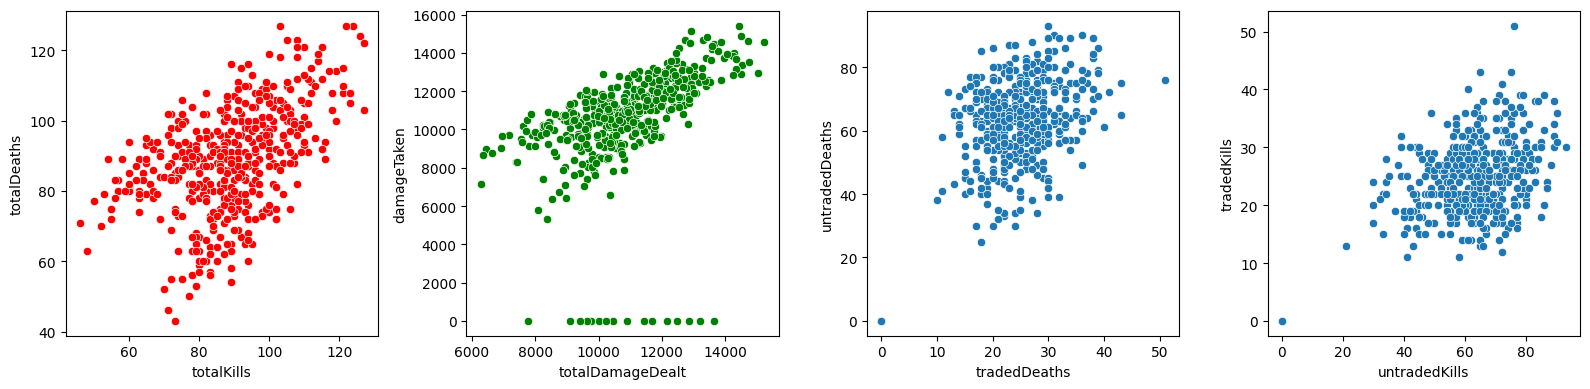

In [15]:
# Remove rows with missing data
hp_df = hp_df[hp_df['totalKills']>45]

# Re-plot graphs
fig = plt.figure(figsize=(16, 4), layout='tight')
ax1, ax2, ax3, ax4 = fig.subplots(ncols=4)

sns.scatterplot(data=hp_df, x='totalKills', y='totalDeaths', ax=ax1, color='red')
sns.scatterplot(data=hp_df, x='totalDamageDealt', y='damageTaken', ax=ax2, color='green')
sns.scatterplot(data=hp_df, x='tradedDeaths', y='untradedDeaths', ax=ax3)
sns.scatterplot(data=hp_df, x='untradedKills', y='tradedKills', ax=ax4);

Moving on to the second plot, I can clearly see that there are a large number of maps where a teams damageTaken is 0, while there totalDamageDealt remains correct. To impute these values, I will take the average damage delta (totalDamageDealt-damageTaken) in both a win and a loss and add that to the damageTaken.  
E.g., 
Damage Dealt = 1000, Damage Taken = 1050 (for a loss)
If the average damage delta is then -50 for a loss, damageTaken for each loss (where there is missing data) will be imputed as totalDamageDealt - (-50)  
I will first determine whether or not to use mean or median as the 'average' whilst imputing by plotting the normal distributions for both winners and losers

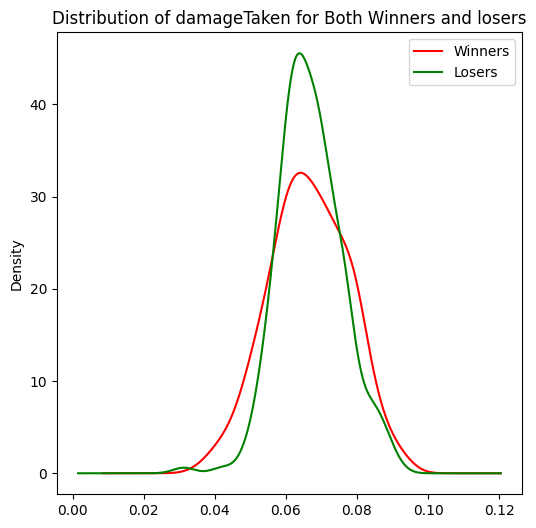

In [16]:
# Import required libraries
from sklearn.preprocessing import normalize
import numpy as np

# Separate df into dfs for winners and losers
df_winners = hp_df.copy()[hp_df['is_winner']==1]
df_losers = hp_df.copy()[hp_df['is_winner']==0]

# Plot normal distributions

fig = plt.figure(figsize=(6, 6))
ax1 = fig.subplots()

valid_damage_w = df_winners[df_winners['damageTaken']>0]['damageTaken']
norm_data_w = normalize(np.array(valid_damage_w).reshape(1, -1))
pd.Series(norm_data_w[0]).plot.density(ax=ax1, label='Winners', color='red')

valid_damage_l = df_losers[df_losers['damageTaken']>0]['damageTaken']
norm_data_l = normalize(np.array(valid_damage_l).reshape(1, -1))
pd.Series(norm_data_l[0]).plot.density(ax=ax1, label='Losers', color='green')

ax1.legend(loc='upper right')
ax1.set_title("Distribution of damageTaken for Both Winners and losers");


From the above plot, I have determined that the mean can be used as an average as the disribution isn't extremely skewed

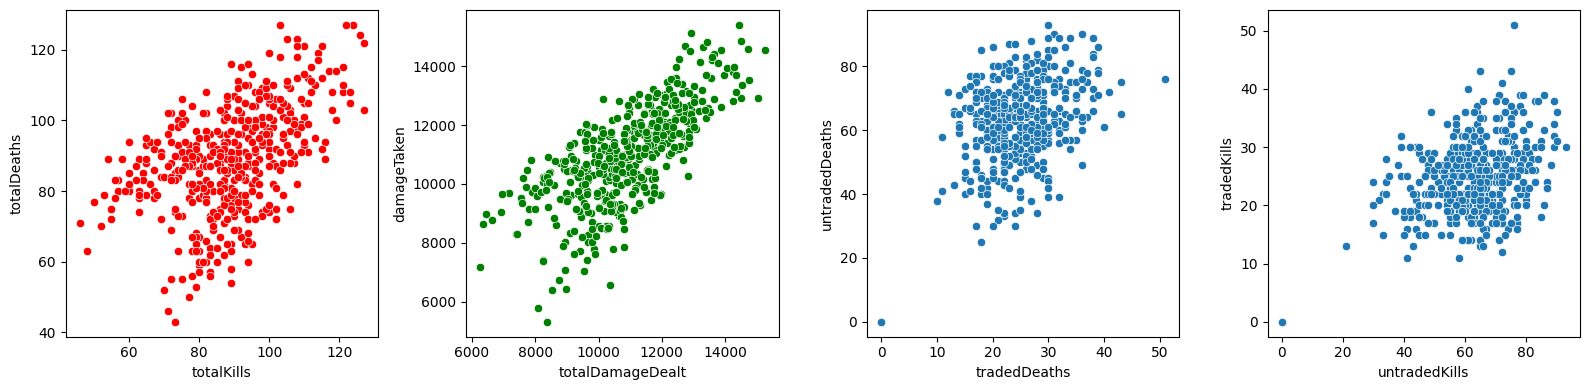

In [17]:
def impute_damage_taken(df):
    """
    Desc: A function to impute the damageTaken if damageTaken = 0 
    """
    clean_data = df.copy()[df['damageTaken']>0]
    clean_data['damageDelta'] = clean_data['totalDamageDealt']-clean_data['damageTaken']
    average = clean_data['damageDelta'].mean()
    df['damageTaken'] = [og if og != 0 else dealt-average for og, dealt in zip(df['damageTaken'], df['totalDamageDealt'])]
    return df

# Separate the data into two dfs for winners and losers
df_winners = impute_damage_taken(df_winners)
df_losers = impute_damage_taken(df_losers)

# Combined both dfs now that damageTaken has been imputed
damage_imp_df = pd.concat([df_winners, df_losers], axis=0)

# Plot the results
fig = plt.figure(figsize=(16, 4), layout='tight')
ax1, ax2, ax3, ax4 = fig.subplots(ncols=4)

sns.scatterplot(data=damage_imp_df, x='totalKills', y='totalDeaths', ax=ax1, color='red')
sns.scatterplot(data=damage_imp_df, x='totalDamageDealt', y='damageTaken', ax=ax2, color='green')
sns.scatterplot(data=damage_imp_df, x='tradedDeaths', y='untradedDeaths', ax=ax3)
sns.scatterplot(data=damage_imp_df, x='untradedKills', y='tradedKills', ax=ax4);

It is clear that this method has worked in removing certain anomalies from the data. Moving on to the next graph, I can see that there are instances where there are no tradedDeaths or untradedDeaths being recorded. Because this data can not be imputed (as they are opposites), the rows will be dropped. 

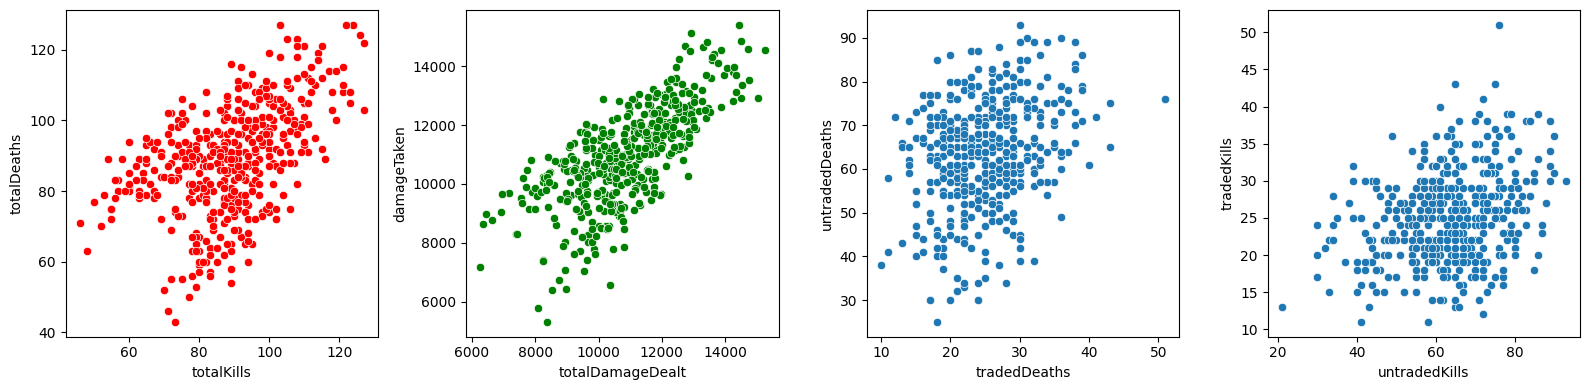

In [18]:
# Remove instances where tradedDeaths == 0
damage_imp_df = damage_imp_df[damage_imp_df['tradedDeaths']>0]

# Plot Results
fig = plt.figure(figsize=(16, 4), layout='tight')
ax1, ax2, ax3, ax4 = fig.subplots(ncols=4)

sns.scatterplot(data=damage_imp_df, x='totalKills', y='totalDeaths', ax=ax1, color='red')
sns.scatterplot(data=damage_imp_df, x='totalDamageDealt', y='damageTaken', ax=ax2, color='green')
sns.scatterplot(data=damage_imp_df, x='tradedDeaths', y='untradedDeaths', ax=ax3)
sns.scatterplot(data=damage_imp_df, x='untradedKills', y='tradedKills', ax=ax4);

Looking at the final graph, I can see that there aren't issues where untradedKills/tradedKills == 0, therefore I will leave this data as it is.

In [19]:
# Display a list of columns in the data
damage_imp_df.columns.values

array(['abbrev', 'matchGame.matchId', 'gameMap', 'gameMode', 'totalKills',
       'totalDeaths', 'totalRotationKills', 'is_winner',
       'totalDamageDealt', 'damageTaken', 'tradedDeaths', 'tradedKills',
       'untradedKills', 'untradedDeaths'], dtype=object)

In [20]:
columns_to_drop = ['abbrev', 'matchGame.matchId', 'gameMap', 'gameMode']

# Reasons for dropping each column
# abbrev - This is no longer required as we don't want our model to be biased towards any
#          individual teams
# matchGame.matchId - This is no longer needed as we don't need to know what match each
#                     row of data is from
# gameMap - We no longer need the map as we are only predicting the winner of a harpdoint
#           game, not map specific
# gameMode - We no longer need the gameMode column as we know that the only gamemode 
#            included in the data is hardpoint

# Drop the columns that aren't needed
damage_imp_df.drop(columns_to_drop, axis=1, inplace=True)
print(f"The remaining columns in the dataset are: {damage_imp_df.columns.values}")
damage_imp_df.sample(5)


The remaining columns in the dataset are: ['totalKills' 'totalDeaths' 'totalRotationKills' 'is_winner'
 'totalDamageDealt' 'damageTaken' 'tradedDeaths' 'tradedKills'
 'untradedKills' 'untradedDeaths']


,totalKills,totalDeaths,totalRotationKills,is_winner,totalDamageDealt,damageTaken,tradedDeaths,tradedKills,untradedKills,untradedDeaths
280,72.0,84.0,16.0,0,9039.0,9480.0,20.0,30.0,42.0,64.0
322,91.0,87.0,19.0,0,11038.0,10945.0,27.0,26.0,65.0,60.0
145,96.0,86.0,19.0,0,11432.0,11017.0,29.0,30.0,66.0,57.0
144,108.0,97.0,27.0,1,12965.0,12480.0,25.0,29.0,79.0,72.0
141,87.0,81.0,14.0,0,11065.0,9663.0,21.0,21.0,67.0,60.0


In [21]:
print(f"The shape of the data has changed from {all_matches.shape} to {damage_imp_df.shape}\nThis is a change of {all_matches.shape[0]-hp_df.shape[0]} rows and {all_matches.shape[1]-damage_imp_df.shape[1]} columns")

The shape of the data has changed from (4352, 104) to (440, 10)
This is a change of 3896 rows and 94 columns


Now that the data has been cleaned, I will take a final look at the data to ensure that there is no unclean data still in the dataset.

In [22]:
print(f"There are {damage_imp_df.isna().sum().sum()} NULLs in the data\n")
damage_imp_df.info();

There are 0 NULLs in the data

<class 'pandas.core.frame.DataFrame'>
Index: 440 entries, 0 to 455
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   totalKills          440 non-null    float64
 1   totalDeaths         440 non-null    float64
 2   totalRotationKills  440 non-null    float64
 3   is_winner           440 non-null    int64  
 4   totalDamageDealt    440 non-null    float64
 5   damageTaken         440 non-null    float64
 6   tradedDeaths        440 non-null    float64
 7   tradedKills         440 non-null    float64
 8   untradedKills       440 non-null    float64
 9   untradedDeaths      440 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 37.8 KB


Before beginning to analyse the data, I will create some new variables from the pre-existing variable to remove bias that could be introduced by not normalizing the data between different maps. For example, one map could on average have more kills per game than another, therefore each statistic should be represented as a percentage (excl. damage). An example of this is removing totalKills and totalDeaths and using K/D ratio (totalKills/totalDeaths)

In [23]:
damage_imp_df['kd'] = damage_imp_df['totalKills']/damage_imp_df['totalDeaths']
damage_imp_df['percRotationKills'] = damage_imp_df['totalRotationKills']/damage_imp_df['totalKills']
damage_imp_df['percTradedDeaths'] = damage_imp_df['tradedDeaths']/damage_imp_df['totalDeaths']
damage_imp_df['percUntradedDeaths'] = damage_imp_df['untradedDeaths']/damage_imp_df['totalDeaths']
damage_imp_df['percTradedKills'] = damage_imp_df['tradedKills']/damage_imp_df['totalKills']
damage_imp_df['percUntradedKills'] = damage_imp_df['untradedKills']/damage_imp_df['totalKills']
damage_imp_df['damageDelta'] = damage_imp_df['totalDamageDealt']-damage_imp_df['damageTaken']

required_columns = ['kd', 'percRotationKills', 'percTradedDeaths', 'percUntradedDeaths', 'percTradedKills', 'percUntradedKills', 'damageDelta', 'is_winner']

cleaned_df = damage_imp_df.copy()[required_columns]
cleaned_df.sample(3)

,kd,percRotationKills,percTradedDeaths,percUntradedDeaths,percTradedKills,percUntradedKills,damageDelta,is_winner
24,0.803922,0.268293,0.225490,0.764706,0.304878,0.695122,-846.0,0
126,0.670886,0.207547,0.240506,0.759494,0.396226,0.603774,-2551.0,0
178,1.043478,0.260417,0.347826,0.652174,0.302083,0.697917,127.0,1


## Step 2 - Data Analysis  
#### In order to better understand the data, I will look at the extremes, the relationships between variables and the differences between different rows.  This will allow for me to recognise trends in the dataset, therefore having better knowledge of what variables (features) will contribute to my model the most.


To begin with, I will plot a correlation matrix which should allow me to understand the relationships between variables. This may also help me get an idea of how many columns to remove using PCA later on. I will be measuring correlation using spearman correlation as the data is not normalised

In [24]:
cleaned_df.corr(method='spearman').style.background_gradient(cmap='coolwarm')

,kd,percRotationKills,percTradedDeaths,percUntradedDeaths,percTradedKills,percUntradedKills,damageDelta,is_winner
kd,1.000000,-0.044672,0.505023,-0.494165,-0.496156,0.493464,0.913437,0.788753
percRotationKills,-0.044672,1.000000,-0.115569,0.122199,-0.007906,0.009296,-0.026790,-0.085978
percTradedDeaths,0.505023,-0.115569,1.000000,-0.980394,-0.093246,0.103940,0.413369,0.387286
percUntradedDeaths,-0.494165,0.122199,-0.980394,1.000000,0.113949,-0.090422,-0.431818,-0.383885
percTradedKills,-0.496156,-0.007906,-0.093246,0.113949,1.000000,-0.971668,-0.428143,-0.382616
percUntradedKills,0.493464,0.009296,0.103940,-0.090422,-0.971668,1.000000,0.401276,0.384370
damageDelta,0.913437,-0.026790,0.413369,-0.431818,-0.428143,0.401276,1.000000,0.733798
is_winner,0.788753,-0.085978,0.387286,-0.383885,-0.382616,0.384370,0.733798,1.000000


At first glance, I can see that the 'percRotationKills' variable not only has little correlation to is_winner (what we're trying to predict), but it also doesn't have much correlation to the other variables in the dataset. Because of this, I will be dropping the column from the data.

In [25]:
# Drop column percRotationKills
cleaned_df.drop("percRotationKills", axis=1, inplace=True);

It is also clear that the two most correlated variables to is_winner are damageDelta and kd. Because of this, I will plot them against eachother to observe the relationship

In [26]:
# Plot correltaion matrix for damageDelta, is_winner and kd
cleaned_df.copy()[['kd', 'is_winner', 'damageDelta']].corr(method='spearman').style.applymap(lambda x: "background-color:red" if x > 0.8 else "background-color:orange;color:black")

,kd,is_winner,damageDelta
kd,1.000000,0.788753,0.913437
is_winner,0.788753,1.000000,0.733798
damageDelta,0.913437,0.733798,1.000000


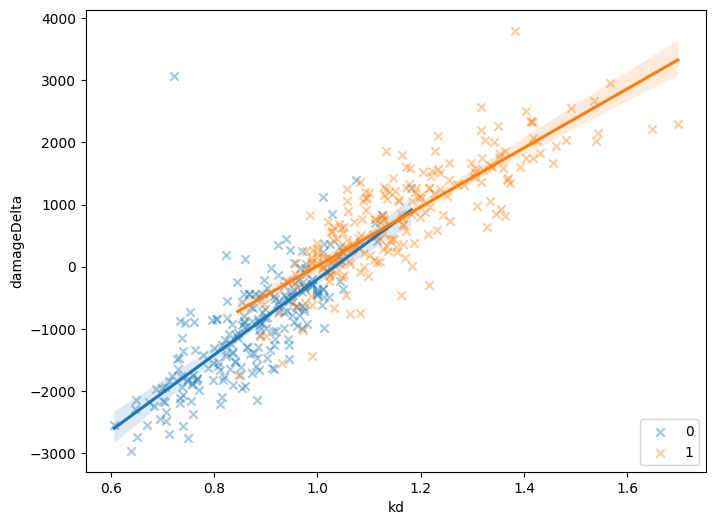

In [27]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.subplots()
for outcome in [0, 1]:
    sns.regplot(ax=ax1, data=cleaned_df[cleaned_df['is_winner']==outcome], x='kd', y='damageDelta', seed=123, marker='x', scatter_kws={"alpha":0.4}, label=outcome)
ax1.legend(loc="lower right");

It is evident that there is one outlier for a losing team, where their damageDelta is extremely positive despite having an extremely low KD.

In [28]:
cleaned_df[cleaned_df['damageDelta']> 3000]

,kd,percTradedDeaths,percUntradedDeaths,percTradedKills,percUntradedKills,damageDelta,is_winner
347,1.382353,0.308824,0.514706,0.202128,0.457447,3797.0,1
426,0.723404,0.106383,0.404255,0.191176,0.308824,3070.0,0


In [29]:
# Create a copy of the team dataframe so that the correct game can be found
testing_df = team_df.copy()
testing_df['kd'] = testing_df['totalKills']/testing_df['totalDeaths']

# Narrow down the dataframe to find the game because of rounding errors
testing_df = testing_df[testing_df['kd'] > 0.723400]
testing_df = testing_df[testing_df['kd'] < 0.72342]
testing_df

,abbrev,matchGame.matchId,gameMap,gameMode,totalKills,totalDeaths,totalRotationKills,is_winner,totalDamageDealt,damageTaken,tradedDeaths,tradedKills,untradedKills,untradedDeaths,kd
997,TX,8691,Breenbergh Hotel,CDL Hardpoint,68.0,94.0,13.0,0,8383.0,5313.0,10.0,13.0,21.0,38.0,0.723404


I can see that the anomaly is from one of OpTic Texas' (TX) games, with match ID 8691, on Breenbergh Hotel.

In [30]:
# Select the relevant map and the relevant columns
match_8691 = all_matches[all_matches['matchGame.matchId']==8691]
hotel_8691 = match_8691[match_8691['gameMap']=='Breenbergh Hotel']
hotel_8691[['alias', 'totalDamageDealt', 'damageTaken', 'totalKills', 'totalDeaths']]

,alias,totalDamageDealt,damageTaken,totalKills,totalDeaths
2000,Shotzzy,1957.0,2424.0,18.0,22.0
2001,Accuracy,1896.0,1970.0,14.0,18.0
2002,iLLeY,2164.0,NaN,16.0,21.0
2003,Mack,2231.0,2536.0,20.0,23.0
2004,Huke,2283.0,NaN,18.0,25.0
2005,Sib,3117.0,NaN,32.0,12.0
2006,Dashy,1979.0,2889.0,16.0,26.0
2007,Pred,3114.0,2055.0,28.0,15.0


Here I can see that there are NULL values for the individual damageTaken for different players (iLLey, Huke and Sib). Because of the small sample that this issue impacts (2 rows), I will remove this row from the dataset. This impacts 2 rows because there are NULLs on each team. The other row which it impacts also appears as an outlier on the plots showing kd vs damageDelta

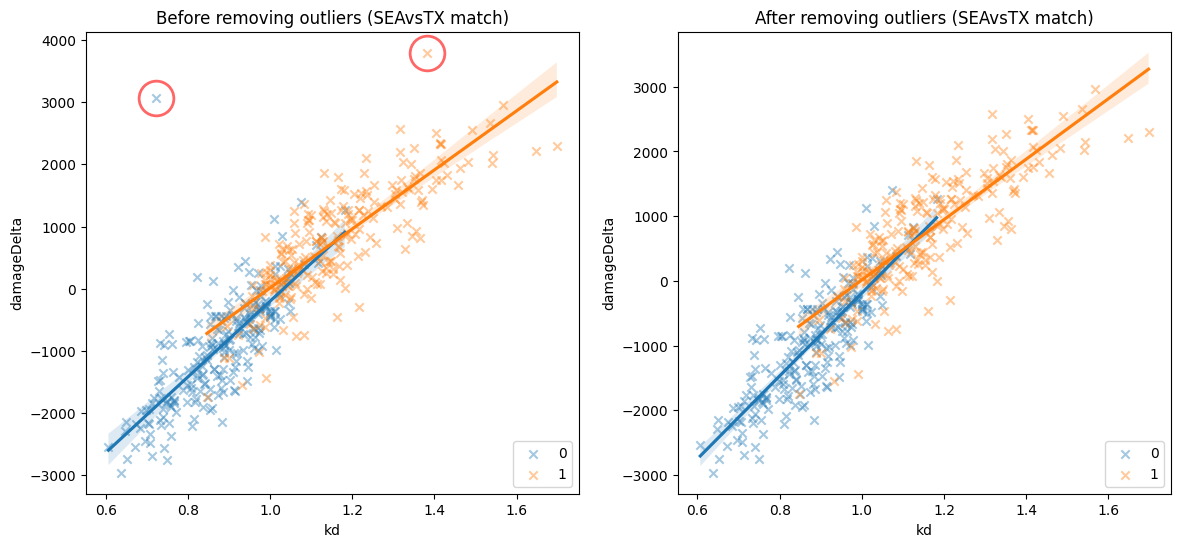

In [31]:
# Create a copy to show visually
cleaned_with_outlier = cleaned_df.copy()

# Drop row at index 426
cleaned_df.drop([426, 347], axis=0, inplace=True)

fig = plt.figure(figsize=(14, 6))
ax1, ax2 = fig.subplots(ncols=2)

# function to plot a circle around a point
def plot_circle(x, y, radius, axis, colour):
    axis.plot(x, y, 'o', ms=radius, mec=colour, mew=2, mfc='none', alpha=0.6)

# Plot old data
for outcome, colour in zip([0, 1], ['#1f77b4', '#ff7f0e']):
    sns.regplot(ax=ax1, data=cleaned_with_outlier[cleaned_with_outlier['is_winner']==outcome], x='kd', y='damageDelta', seed=123, marker='x', scatter_kws={"alpha":0.4}, label=outcome, color=colour)
ax1.legend(loc="lower right");
ax1.set_title("Before removing outliers (SEAvsTX match)")

# Plot new data with the outliers removed
for outcome, colour in zip([0, 1], ['#1f77b4', '#ff7f0e']):
    sns.regplot(ax=ax2, data=cleaned_df[cleaned_df['is_winner']==outcome], x='kd', y='damageDelta', seed=123, marker='x', scatter_kws={"alpha":0.4}, label=outcome, color=colour)
ax2.legend(loc="lower right");
ax2.set_title("After removing outliers (SEAvsTX match)");

# Annotate outliers (from above dataframe extract)
plot_circle(1.382353, 3797.0, 25, ax1, "red")
plot_circle(0.723404, 3070.0, 25, ax1, "red")

From plotting kd vs damageDelta, I can see that there is a direct correlation not only between kd and damageDelta, but also with winning the map. As the kd (of the team) increases, so does the damageDelta, meaning that it is very unlikely for a team to do more damage but end up with a lower K/D ratio. As the damage and the KD increases, so does the chance of winning. On the plot, it can be seen that the teams with the highest K/D ratio's and damageDelta's are wommomg their matches, whilst the teams with lower K/D ratio's and damageDelta's are losing.

Now that these outliers have been removed, I will reset the index of the dataframe

In [32]:
#Reset index inplace
cleaned_df.reset_index(inplace=True, drop=True)
cleaned_df.head(5)

,kd,percTradedDeaths,percUntradedDeaths,percTradedKills,percUntradedKills,damageDelta,is_winner
0,1.324324,0.229730,0.770270,0.244898,0.755102,2042.0,1
1,1.050000,0.262500,0.737500,0.309524,0.690476,538.0,1
2,1.161765,0.294118,0.705882,0.227848,0.772152,-460.0,1
3,1.217391,0.159420,0.840580,0.226190,0.773810,962.0,1
4,1.373134,0.253731,0.746269,0.206522,0.793478,1354.0,1


To explore other variables from the dataset, I will plot the remaining variables (percTradedDeaths, percUntradedDeaths, percTradedKills, percUntradedKills) against eachother to identify relationships between them. They are not expected to perform as well as damageDelta and kd in terms of correlating with the outcome of a map, as seen in the correlation matrix previously plotted.

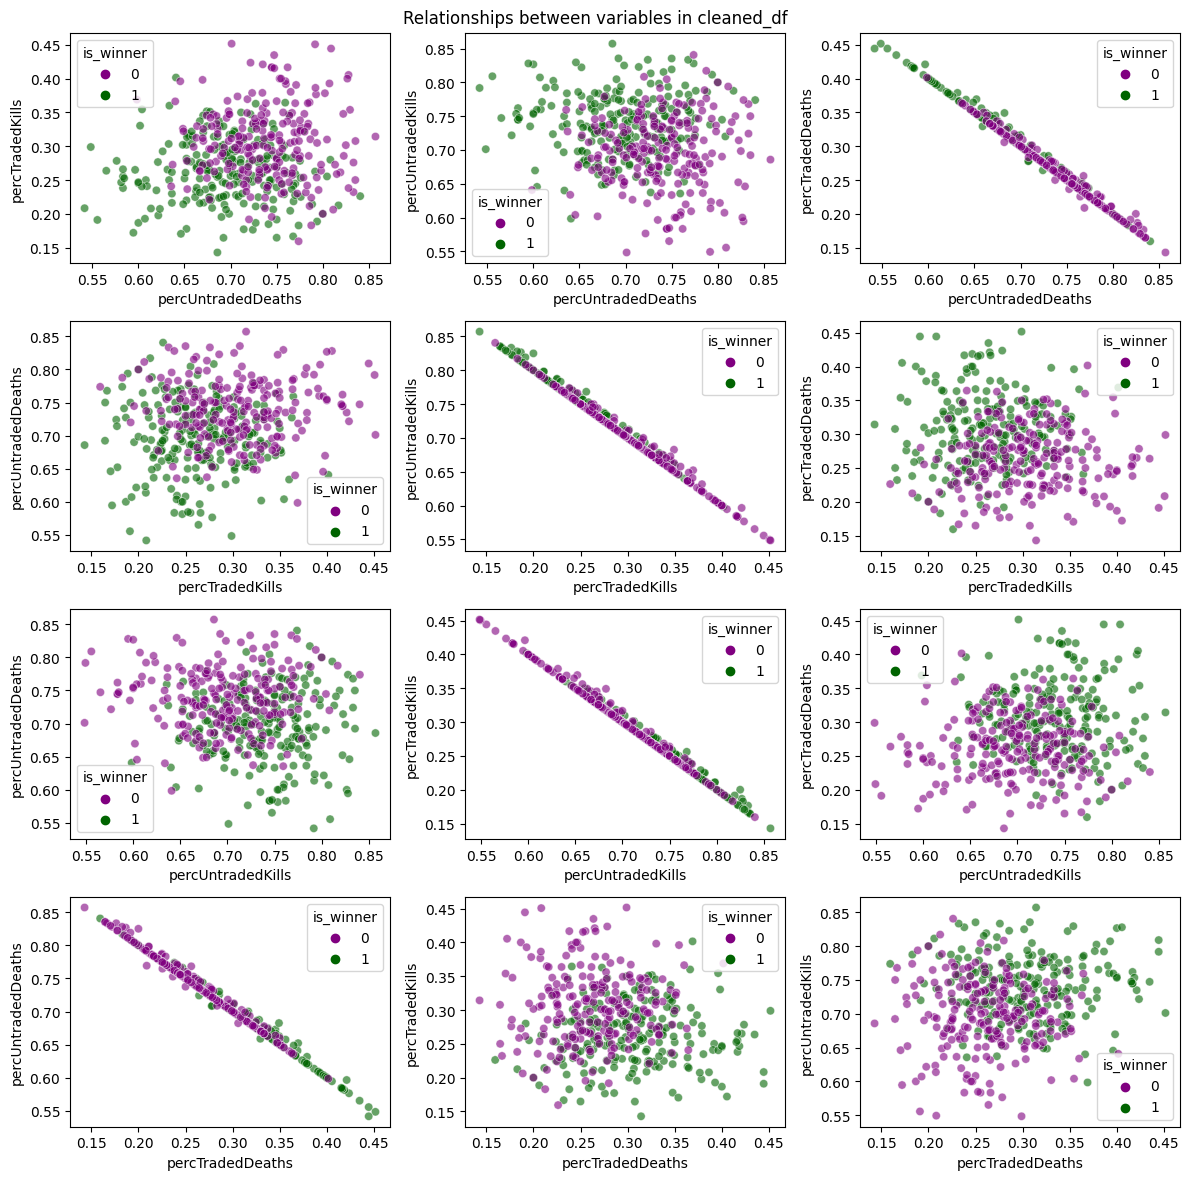

In [33]:
fig = plt.figure(figsize=(12, 12), layout='tight')
axes = fig.subplots(ncols=3, nrows=4)

variables = ['percUntradedDeaths','percTradedKills','percUntradedKills','percTradedDeaths']
for x, var in enumerate(variables):
    for y, sub_var in enumerate([i for i in variables if i != var]):
        sns.scatterplot(data=cleaned_df, x=var, y=sub_var, ax=axes[x][y], hue='is_winner', palette=['purple', 'darkgreen'], alpha=0.6)

fig.suptitle("Relationships between variables in cleaned_df");

The relationships between the following pairs 
- percTradedDeaths and percUntradedDeaths 
- percUntradedKills and percTradedKills   
are clearly shown in the graphs. This is expected as they are 'opposites' of eachother.  

Also while there isn't a strong relationship between the variables, there are distinctive groups between the winners and losers for other variable pairings.  
For example, when comparing percTradedKills and percUntradedDeaths (row 2, column 1), there is clearly a mix in the middle, with losers appearing towards the upper right of the central cluster and winners appear to the lower left

## Step 3 - Dimensionality Reduction  
#### So that the number of columns can be reduced, I will explore dimensionality reduciton, specificely PCA (Principal Component Analysis). Using dimensionality reduction will make my model less computationally expensive. I may not be able to reduce the number of columns in the dataset however if the explained variance (%) becomes too small.



In [34]:
# Import Required Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Split the data into features (y) and labels (X)
y = cleaned_df["is_winner"]
X = cleaned_df.copy().drop("is_winner", axis=1)

# Standardise the data (features only)
standard_df = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)
standard_df.sample(3)

,kd,percTradedDeaths,percUntradedDeaths,percTradedKills,percUntradedKills,damageDelta
166,0.659889,-0.229982,0.201017,0.832733,-0.867471,1.271177
214,0.337530,0.660820,-0.689021,-1.167586,1.131709,-0.530343
76,0.356278,1.135066,-1.162859,-1.163616,1.127741,0.726666


After standardising the data, I can see that the damageDelta variable is now measured on the same scale as the rest of the varibales (which were previously measured as ratios/percentages).
I will now try PCA on the dataset with various different number of components. This will allow for me to calculate the explained variance for different numbers of components, allowing me to choose the best number of component to keep after PCA.

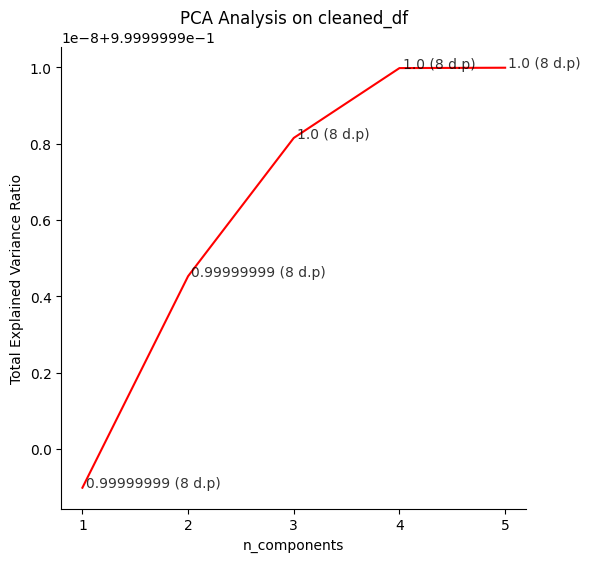

In [35]:
# Create two arrays/lists to store results of PCA analysis
n_components = []
explained_variance = []

for i in range(1, standard_df.shape[1]):
    current_pca = PCA(n_components=i)
    current_pca.fit_transform(X=X)
    n_components.append(i)
    explained_variance.append(current_pca.explained_variance_ratio_.sum())

# Plot the results
fig = plt.figure(figsize=(6, 6))
ax1 = fig.subplots()
ax1.plot(n_components, explained_variance, color='red')

# Annotate points on the graph
for x, y in zip(n_components, explained_variance):
    plt.text(x+0.03, y, f"{round(y, 8)} (8 d.p)", alpha=0.8)
ax1.spines[['top', 'right']].set_visible(False)
ax1.set_xticks(n_components)

# Set labels and title
ax1.set_xlabel("n_components")
ax1.set_ylabel("Total Explained Variance Ratio")
ax1.set_title("PCA Analysis on cleaned_df");

After plotting the results of the PCa analysis on the claned dataset, I can see that the loss of explained variance from reducing the number of dimensions (through columns) is minimal. Because of this, I have decided to continue with the current number of columns in the dataset, and not complete PCA before training my random forest model. 

## Step 4 - Random Forest
#### Now that I have my dataset cleaned, with the a reasonable number of columns, I can begin to train my model and carry our hyperparameter tuning in order to to fit the model in the best way possible, without overfitting.  
#### I have decided to use a Random Forest model as I believe that it is going to be not only quick to train, but will also predict the outcome of a CDL hardpoint match with a high degree of accuracy.

In [36]:
# Import Requried Libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split

# Split my dataset into train and test data (80-20 % split)
y = cleaned_df["is_winner"]
X = cleaned_df.copy().drop("is_winner", axis=1)

testX, trainX, testY, trainY = train_test_split(X, y, test_size=0.8, random_state=123)
print(f"The size of the original data is: X {X.shape}, Y {y.shape}")
print(f"The size of the training data is: X {trainX.shape}, Y {trainY.shape}")
print(f"The size of the testing data is: X {testX.shape}, Y {testY.shape}")

The size of the original data is: X (438, 6), Y (438,)
The size of the training data is: X (351, 6), Y (351,)
The size of the testing data is: X (87, 6), Y (87,)


Now that I have split my data into train and test data, I will fit the model without any hyperparamter tuning to determine the initial accuracy of a random forest model on predicting the outcome of a CDL hardpoint match.

The intial accuracy of the model (to 7 d.p) without any hyperparameter tuning is 0.9195402 or 91.95402%
The intial recall of the model (to 7 d.p) without any hyperparameter tuning is 0.9285714 or 92.85714%
The intial precision of the model (to 7 d.p) without any hyperparameter tuning is 0.9069767 or 90.69767%


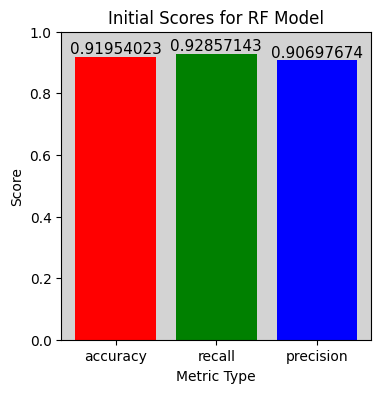

In [37]:
# Fit the model and predict y
rf = RandomForestClassifier()
rf.fit(trainX, trainY)
y_prediction = rf.predict(testX)

# Calculate the inital scores
initial_accuracy = accuracy_score(testY, y_prediction)
initial_recall = recall_score(testY, y_prediction)
initial_precision = precision_score(testY, y_prediction)

#Print the results to higher precision (decimal places) than the plot
print(f"The intial accuracy of the model (to 7 d.p) without any hyperparameter tuning is {round(initial_accuracy, 7)} or {round(initial_accuracy*100, 5)}%")
print(f"The intial recall of the model (to 7 d.p) without any hyperparameter tuning is {round(initial_recall, 7)} or {round(initial_recall*100, 5)}%")
print(f"The intial precision of the model (to 7 d.p) without any hyperparameter tuning is {round(initial_precision, 7)} or {round(initial_precision*100, 5)}%")

# Plot the results
fig = plt.figure(figsize=(4, 4))
ax1 = fig.subplots()

scores = [initial_accuracy, initial_recall, initial_precision]
ax1.bar(x=["accuracy", "recall", "precision"], height=scores, color=['red', 'green', 'blue'])
ax1.set_ylim(bottom=0, top=1);

# Write the scores onto the plot
for x, y in zip(ax1.get_xticks(), scores):
    ax1.text(x, y, round(y, 8), size=11, horizontalalignment='center', verticalalignment='bottom')

# Format the plot with labels/titles and colours
ax1.set_title("Initial Scores for RF Model")
ax1.set_xlabel("Metric Type")
ax1.set_ylabel("Score")
ax1.set_facecolor("lightgrey")


From the initial scores, I can see that my model is relatively accurate (around 90%) in predicting the winner of a CDL hardpoint match up before hyperparameter tuning. In order to improve this accuracy, I will complete a grid search with different hyperparameters. I have decided to score using accuracy because in my model, the cost of false positives and false negatives are similar.

In [38]:
# Declare the parameters
param_ranges = {"n_estimators":[i for i in range(50, 150)],
                "max_depth": [i for i in range(3, 12)]}

# Complete a Cross Validation Grid Search and fit the model
grid_search_rf = RandomForestClassifier()
grid_search = GridSearchCV(grid_search_rf, 
                             param_grid=param_ranges,
                             cv=2,
                             scoring='accuracy')

grid_search.fit(trainX, trainY);

In [39]:
print(f"The best parameters for my model are: {grid_search.best_params_}\nThe accuracy for these parameters is: {grid_search.best_score_}")

The best parameters for my model are: {'max_depth': 3, 'n_estimators': 97}
The accuracy for these parameters is: 0.8975487012987013


According to my Cross Validated Grid Search, the best paramters to use for my random forest model are max depth = 3 and n_estimators = 55 (subject to change on re runs). I will now measure the f1 score, recall, precision and accuracy for this model to get a better idea of how accurate it is. 

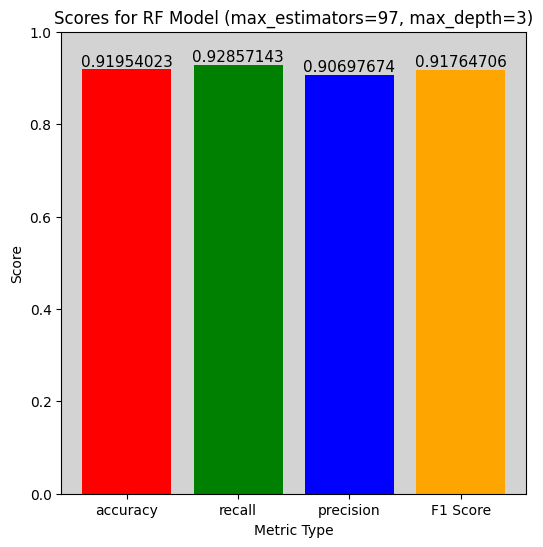

In [40]:
# Import required libraries
from sklearn.metrics import f1_score

# Create and fit my model
best_params = grid_search.best_params_
n_esti = best_params['n_estimators']
md = best_params['max_depth']

main_rf = RandomForestClassifier(n_estimators=n_esti, max_depth=md)
main_rf.fit(X=trainX, y=trainY)
y_pred = main_rf.predict(testX)

# Calculate Scores
main_f1 = f1_score(testY, y_pred)
main_acc = accuracy_score(testY, y_pred)
main_precision = precision_score(testY, y_pred)
main_recall = recall_score(testY, y_pred)

new_scores = [main_acc, main_recall, main_precision, main_f1]

# Plot the scores
fig = plt.figure(figsize=(6, 6))
ax1 = fig.subplots()

ax1.bar(x=["accuracy", "recall", "precision", "F1 Score", ], height=new_scores, color=['red', 'green', 'blue', 'orange'])
ax1.set_ylim(bottom=0, top=1);

for x, y in zip(ax1.get_xticks(), new_scores):
    ax1.text(x, y, round(y, 8), size=11, horizontalalignment='center', verticalalignment='bottom')

ax1.set_xlabel("Metric Type")
ax1.set_ylabel("Score")
ax1.set_title(f"Scores for RF Model (max_estimators={n_esti}, max_depth={md})");
ax1.set_facecolor('lightgrey')


After carrying out cross validation, it is evident that my overall accuracy has not improved. This is unfortunate however the intial accuracy of > 90% is still very good.  I will now plot the scores for each combination of n_estimators and max_depth to visualise the combinations that return the best possible scores (accuracy).

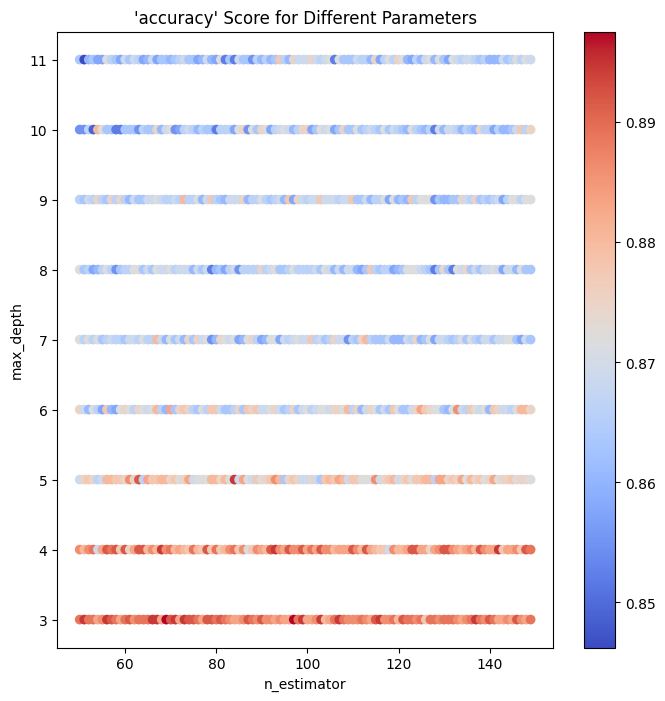

In [41]:
all_scores = grid_search.cv_results_

# Plot accuracy for all parameter combonations
fig = plt.figure(figsize=(8, 8))
ax1 = fig.subplots()

scatter = ax1.scatter(x=all_scores['param_n_estimators'], y=all_scores['param_max_depth'], c=all_scores['mean_test_score'], cmap='coolwarm')
fig.colorbar(scatter);
ax1.set_title("'accuracy' Score for Different Parameters");
ax1.set_xlabel("n_estimator")
ax1.set_ylabel("max_depth");

This plot shows that there are more often much more accurate models when the max_depth is 4 or less, rather than a larger number. There are however instances where the accuracy score reaches the high 0.8s where the max depth is larger, although it is not as common.

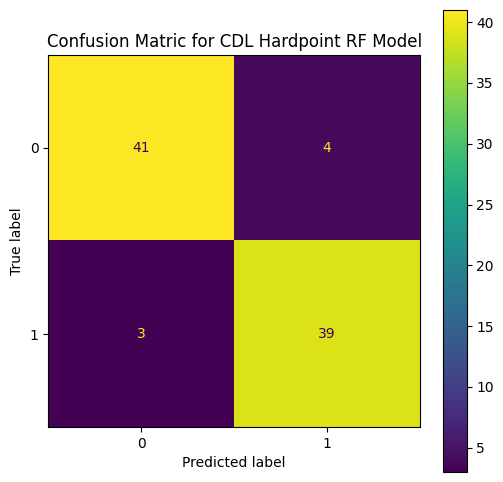

In [42]:
# Create confusion matrix
cm = confusion_matrix(testY, y_pred)

# Plot confusion matrix
fig = plt.figure(figsize=(6, 6))
ax1 = fig.subplots()

ConfusionMatrixDisplay(cm).plot(ax=ax1);
ax1.set_title("Confusion Matric for CDL Hardpoint RF Model");

The confusion matrix shows that my model is getting the same number of false positives as it is false negatives. This indicates that 'accuracy' is an accurate metric to grade the model rather than F1 score (which uses recall and precision, more necessary for models with a less equal number of false positives and false negatives).  
Overall, There are a small number of incorrect results, with marginally more false positives than false negatives (4 vs 3).  

Next, I will look at what features of the dataset are contributing the most to the outcome of the model. This will allow me to understand where my results mainly come from, and what variables aren't contributing large amounts to determining a winner.

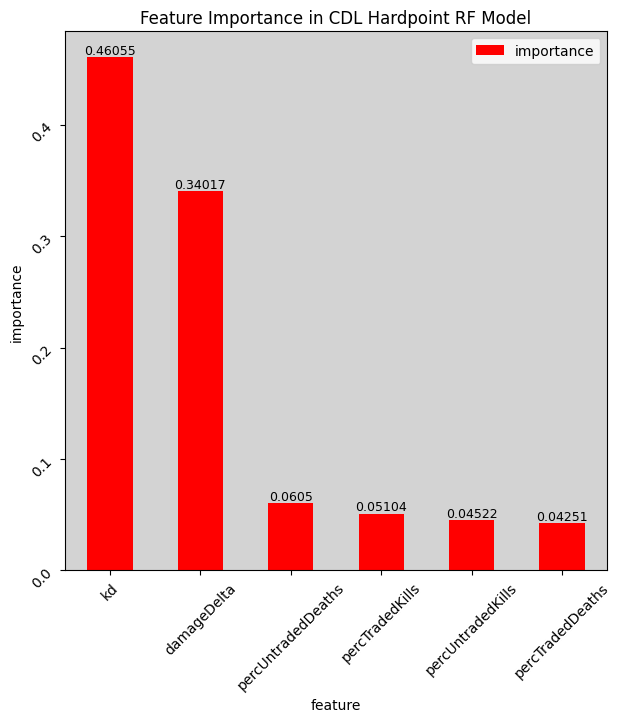

In [43]:
# Create a dataframe containig the importance of each feature
feature_importance_df = pd.DataFrame(main_rf.feature_importances_, index=trainX.columns, columns=['importance']).sort_values(ascending=False, by='importance')

# Plot the importance
fig = plt.figure(figsize=(7, 7))
ax1 = fig.subplots()

feature_importance_df.plot.bar(ax=ax1, color='red')
ax1.set_facecolor('lightgrey')
ax1.set_title("Feature Importance in CDL Hardpoint RF Model")
ax1.set_xlabel("feature")
ax1.set_ylabel(("importance"))
for x, y in zip(ax1.get_xticks(), feature_importance_df.importance):
    ax1.text(x, y, round(y, 5), horizontalalignment='center', verticalalignment='bottom', size=9)

ax1.tick_params(rotation=45)


From the plot, I can see that kd plays the most important part in determining the decision made by the random forest at 0.44. Second to kd is damageDelta, at 0.35 (0.09 less than the most important feature). The least import feature in my model is percTradedKills. All features however excluding kd and damageDelta contirbute to less than 10% of the models decision, with the largest being percUntradedDeaths at 0.06612,

## Model Evaluation  
#### Now that I have cleaned and analysed my data, followed by training my random forest model with the best parameters, I can evaluate the performance of the model, along with what I have learnt from the model.  
Firstly, I will consider how accurate the model is at predicting the winner of a CDL hardpoint match. After completing hyperparamater tuning using a grid search cross validation method, my model has an accuracy score of 0.92 (to 2 decimal places). It also has a precision score of 0.907 (3 d.p) and a recall score of 0.929 (3 d.p). This means that there is a higher percentage of relevant results correctly predicted by the model than there is percentage of relevant results. Overall, the model is extremely accurate, proving succesful at predicting the outcome of a CDL hardpoint match about 90% of the time, a reliable score for what is being predicted (does not need to be 100%).  

Moving onto the features that make up the model, the training of the model allowed me to establish which features were the most important in determining the label (CDL hardpoint match winner). From the feature importance plot in my notebook, it is evident that kd (0.46) is the most important feature when predicting the winner of a CDL hardpoint match, meaning the team with a higher KD ratio (Kills/Deaths) is most likely to win. Second to KD is damageDelta (0.34), meaning teams who are dealing more damage than they are taking are most likely to win the CDL hardpoint matchup. This can be related back to KD, as you would need to be dealing more damage than your opponents in order to obtain more kills. Looking at the other features, they are much less important. For example, the third most important feature; percUntradedDeaths, only has an important of 0.061, around 5x lower than the second most important feature.  

Overall, I believe that the cleaning of the data, analysis of the data and fitting of the model was succesful, allowing for me to develop a model that can accurately predict the outcome of a CDL hardpoint match around 90% of the time.